In [1]:
import tensorflow as tf
import numpy as np
import timeit
from scipy.interpolate import griddata
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os



os.environ["KMP_WARNINGS"] = "FALSE" 
import timeit

import sys

import scipy
import scipy.io
import time



import logging

import os.path
import shutil
from datetime import datetime
import pickle

class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name = None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name
    def sample(self, N):
        x = self.coords[0:1,:] + (self.coords[1:2,:]-self.coords[0:1,:])*np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y

# Define the exact solution and its derivatives
def u(x, a, c):
    """
    :param x: x = (t, x)
    """
    t = x[:,0:1]
    x = x[:,1:2]
    return np.sin(np.pi * x) * np.cos(c * np.pi * t) + a * np.sin(2 * c * np.pi* x) * np.cos(4 * c  * np.pi * t)

def u_t(x,a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_t = -  c * np.pi * np.sin(np.pi * x) * np.sin(c * np.pi * t) -  a * 4 * c * np.pi * np.sin(2 * c * np.pi* x) * np.sin(4 * c * np.pi * t)
    return u_t

def u_tt(x, a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_tt = -(c * np.pi)**2 * np.sin( np.pi * x) * np.cos(c * np.pi * t) - a * (4 * c * np.pi)**2 *  np.sin(2 * c * np.pi* x) * np.cos(4 * c * np.pi * t)
    return u_tt

def u_xx(x, a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_xx = - np.pi**2 * np.sin( np.pi * x) * np.cos(c * np.pi * t) -  a * (2 * c * np.pi)** 2 * np.sin(2 * c * np.pi* x) * np.cos(4 * c * np.pi * t)
    return  u_xx


def r(x, a, c):
    return u_tt(x, a, c) - c**2 * u_xx(x, a, c)

def operator(u, t, x, c, sigma_t=1.0, sigma_x=1.0):
    u_t = tf.gradients(u, t)[0] / sigma_t
    u_x = tf.gradients(u, x)[0] / sigma_x
    u_tt = tf.gradients(u_t, t)[0] / sigma_t
    u_xx = tf.gradients(u_x, x)[0] / sigma_x
    residual = u_tt - c**2 * u_xx
    return residual



In [2]:
class PINN:
    # Initialize the class
    def __init__(self, layers, operator, ics_sampler, bcs_sampler, res_sampler, c ,mode ,  sess):
        # Normalization 


        self.mode = mode

        self.dirname, logpath = self.make_output_dir()
        self.logger = self.get_logger(logpath)     

        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_t, self.sigma_t = self.mu_X[0], self.sigma_X[0]
        self.mu_x, self.sigma_x = self.mu_X[1], self.sigma_X[1]

        self.activFun = 'tanh'
        # Samplers
        self.operator = operator
        self.ics_sampler = ics_sampler
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler

        self.sess = sess
        # Initialize network weights and biases
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # weights
        self.loss_list = [ "loss_bc1", "loss_bc2", "loss_ics_u" ] 
        self.lambda_val_list = dict((loss, np.array(2.0) ) for loss in self.loss_list )

        self.lam_u_val = np.array(2.0)
        self.lam_ut_val = np.array(2.0)
        # self.lam_res_val = np.array(1.0)
        self.lam_bc1_val = np.array(2.0)
        self.lam_bc2_val = np.array(2.0)
      
        # Wave constant
        self.c = tf.constant(c, dtype=tf.float32)
        

        # Define Tensorflow session
        self.sess = sess #tf.Session(config=tf.ConfigProto(log_device_placement=False))

        # Define placeholders and computational graph
        self.t_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_u_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        
        self.lam_u_tf = tf.placeholder(tf.float32, shape=self.lam_u_val.shape)
        self.lam_ut_tf = tf.placeholder(tf.float32, shape=self.lam_u_val.shape)
        # self.lam_r_tf = tf.placeholder(tf.float32, shape=self.lam_u_val.shape)
        self.lam_bc1_tf = tf.placeholder(tf.float32, shape=self.lam_bc1_val.shape)
        self.lam_bc2_tf = tf.placeholder(tf.float32, shape=self.lam_bc2_val.shape)
        self.lam_res_tf = tf.placeholder(tf.float32, shape=self.lam_bc2_val.shape)


        self.u_pred = self.net_u(self.t_u_tf, self.x_u_tf)


        # Evaluate predictions
        self.u_ics_pred = self.net_u(self.t_ics_tf, self.x_ics_tf)
        self.u_bc1_pred = self.net_u(self.t_bc1_tf, self.x_bc1_tf)
        self.u_bc2_pred = self.net_u(self.t_bc2_tf, self.x_bc2_tf)

        self.r_pred = self.net_r(self.t_r_tf, self.x_r_tf)
        
        
        # Boundary loss and Initial loss
        self.loss_ics_u = tf.reduce_mean(tf.square(self.u_ics_tf - self.u_ics_pred))
        self.loss_ics_ut = tf.reduce_mean(tf.square( tf.gradients(self.u_ics_pred, self.t_ics_tf)[0] / self.sigma_t) )
        self.loss_bc1 = tf.reduce_mean(tf.square(self.u_bc1_pred)) #+ tf.reduce_mean(tf.square(self.u_bc2_pred))
        self.loss_bc2 = tf.reduce_mean(tf.square(self.u_bc2_pred))

        # Residual loss
        self.loss_res = tf.reduce_mean(tf.square(self.r_pred))

        # Total loss
        self.loss =  self.loss_res + self.lam_bc1_tf * self.loss_bc1 +  self.lam_bc2_tf * self.loss_bc2 + self.lam_u_tf * (self.loss_ics_u + self.loss_ics_ut )

        self.prev_loss = 0.0
        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,  1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)
        

        self.loss_tensor_list = [ self.loss ,  self.loss_res,  self.loss_bc1 , self.loss_bc2 , self.loss_ics_u, self.loss_ics_ut] 

        self.epoch_loss = dict.fromkeys(self.loss_list, 0)
        self.loss_history = dict((loss, []) for loss in self.loss_list)

        self.dict_gradients_res_layers = self.generate_grad_dict()
        self.dict_gradients_bcs1_layers = self.generate_grad_dict()
        self.dict_gradients_bcs2_layers = self.generate_grad_dict()
        self.dict_gradients_ics_layers = self.generate_grad_dict()

        # Gradients Storage
        self.grad_res = []
        self.grad_ics = []
        self.grad_bcs1 = []
        self.grad_bcs2 = []

        for i in range(len(self.layers) - 1):
            self.grad_res.append(tf.gradients(self.loss_res, self.weights[i])[0])
            self.grad_bcs1.append(tf.gradients(self.loss_bc1, self.weights[i])[0])
            self.grad_bcs2.append(tf.gradients(self.loss_bc2, self.weights[i])[0])
            self.grad_ics.append(tf.gradients(self.loss_ics_u, self.weights[i])[0])

        self.mean_grad_res_list = []
        self.mean_grad_bcs1_list = []
        self.mean_grad_bcs2_list = []
        self.mean_grad_ics_list = []

        self.mean_grad_res_log = []
        self.mean_grad_bcs1_log = []
        self.mean_grad_bcs2_log = []
        self.mean_grad_ics_log = []

        self.adaptive_constant_bcs1_log  = []
        self.adaptive_constant_bcs2_log  = []
        self.adaptive_constant_ics_log  = []
        self.adaptive_constant_res_log  = []
    
        for i in range(len(self.layers) - 1):
            self.mean_grad_res_list.append(tf.math.reduce_std(tf.abs(self.grad_res[i]))) 
            self.mean_grad_bcs1_list.append(tf.math.reduce_std(tf.abs(self.grad_bcs1[i])))
            self.mean_grad_bcs2_list.append(tf.math.reduce_std(tf.abs(self.grad_bcs2[i])))
            self.mean_grad_ics_list.append(tf.math.reduce_std(tf.abs(self.grad_ics[i])))

        self.mean_grad_res = tf.math.reduce_std(tf.stack(self.mean_grad_res_list))
        self.mean_grad_bcs1 = tf.math.reduce_std(tf.stack(self.mean_grad_bcs1_list))
        self.mean_grad_bcs2 = tf.math.reduce_std(tf.stack(self.mean_grad_bcs2_list))
        self.mean_grad_ics = tf.math.reduce_std(tf.stack(self.mean_grad_ics_list))
        
        self.adaptive_constant_bcs1 =  self.mean_grad_res / self.mean_grad_bcs1
        self.adaptive_constant_bcs2 = self.mean_grad_res / self.mean_grad_bcs2
        self.adaptive_constant_ics = self.mean_grad_res / self.mean_grad_ics
        self.adaptive_constant_res = self.mean_grad_res 

        self.lambda_list = [ self.adaptive_constant_res,  self.adaptive_constant_bcs1 , self.adaptive_constant_bcs2 , self.adaptive_constant_ics] 
        self.lambda_list_history = dict((loss, lambda1 ) for loss , lambda1 in zip(self.loss_list ,  self.lambda_list))

         # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return tf.Variable(tf.random.normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,  dtype=tf.float32)

        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluates the forward pass
    def forward_pass(self, H, layers, weights, biases):
        num_layers = len(layers)
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H
       
################################################################################################
    # Forward pass for u
    def net_u(self, t, x):
        u = self.forward_pass(tf.concat([t, x], 1),  self.layers, self.weights, self.biases)
        return u

    # Forward pass for du/dt
    def net_u_t(self, t, x):
        u_t = tf.gradients(self.net_u(t, x), t)[0] / self.sigma_t
        return u_t

    # Forward pass for the residual
    def net_r(self, t, x):
        u = self.net_u(t, x)
        residual = self.operator(u, t, x, self.c, self.sigma_t,  self.sigma_x)
        return residual

    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

        # Trains the model by minimizing the MSE loss

    def trainmb(self, nIter=10000, batch_size=128, log_NTK=False, update_lam=False):

        def lambda_balance(self  , term  ):
                histoy_mean =  np.mean(self.loss_history[term])
                m = len(self.loss_list)
                num = np.exp(self.loss_history[term][-1] /(self.T * histoy_mean))
                denum = 0 

                for  key in self.loss_list:
                    denum +=  np.exp(self.loss_history[key][-1] /(self.T * histoy_mean))
                return m * (num / denum)
        
        itValues = [1,100,1000,39999]
        start_time = timeit.default_timer()
        for it in range(1 , nIter):
            # Fetch boundary mini-batches
            X_ics_batch, u_ics_batch = self.fetch_minibatch(self.ics_sampler, batch_size // 3)
            X_bc1_batch, _ = self.fetch_minibatch(self.bcs_sampler[0], batch_size // 3)
            X_bc2_batch, _ = self.fetch_minibatch(self.bcs_sampler[1], batch_size // 3)
            
            # Fetch residual mini-batch
            X_res_batch, _ = self.fetch_minibatch(self.res_sampler, batch_size)
            # Define a dictionary for associating placeholders with data
            tf_dict = {self.t_ics_tf: X_ics_batch[:, 0:1], self.x_ics_tf: X_ics_batch[:, 1:2],
                       self.u_ics_tf: u_ics_batch,
                       self.t_bc1_tf: X_bc1_batch[:, 0:1], self.x_bc1_tf: X_bc1_batch[:, 1:2],
                       self.t_bc2_tf: X_bc2_batch[:, 0:1], self.x_bc2_tf: X_bc2_batch[:, 1:2],
                       self.t_r_tf: X_res_batch[:, 0:1], self.x_r_tf: X_res_batch[:, 1:2],
                       self.lam_u_tf: self.lam_u_val,
                       self.lam_bc1_tf: self.lam_bc1_val,
                       self.lam_bc2_tf: self.lam_bc2_val
                       }

            # Run the Tensorflow session to minimize the loss
            _, batch_losses = self.sess.run([self.train_op, self.loss_tensor_list] ,tf_dict)
            [ loss ,  loss_res,  loss_bc1 , loss_bc2 , loss_ics_u, loss_ics_ut]   = batch_losses

            self.assign_batch_losses(batch_losses)
            for key in self.loss_history:
                self.loss_history[key].append(self.epoch_loss[key])

            # Print
            if  it % 100 == 0:
              
                    elapsed = timeit.default_timer() - start_time
                    # loss ,  loss_res , loss_ics_ut  = self.sess.run([self.loss, self.loss_res ,  self.loss_ics_ut ] ,tf_dict)

                    print('It: %d| Loss: %.3e|  loss_bc1: %.3e|  loss_bc2: %.3e| loss_ics_u: %.3e| loss_ics_ut: %.3e|  Loss_res: %.3e , Time: %.2f' %(it, loss, loss_bc1 , loss_bc2 , loss_ics_u, loss_ics_ut , loss_res , elapsed))


                    for term in self.loss_list:
                        if lambda_balance(self  , term) > 0.0:
                
                            adaptive_constant_lambda = self.sess.run( [self.lambda_list[term] ], tf_dict)
                            self.lambda_val_list[term] = adaptive_constant_lambda #* ( 1.0 - self.rate) + self.rate * self.adaptive_constant_ics_val

                            self.print('updating : ' ,term  , 'lam_res_val: {:.3e}'.format(self.lambda_val_list[term]))
                          
            
            sys.stdout.flush()
            start_time =      timeit.default_timer()
            if it in itValues:
                    self.plot_layerLoss(tf_dict , it)
                    self.print("Gradients information stored ...")

            sys.stdout.flush()
 
    # Evaluates predictions at test points
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_u_tf: X_star[:, 0:1], self.x_u_tf: X_star[:, 1:2]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        return u_star

        # Evaluates predictions at test points

    def predict_r(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_r_tf: X_star[:, 0:1], self.x_r_tf: X_star[:, 1:2]}
        r_star = self.sess.run(self.r_pred, tf_dict)
        return r_star
    
   ###############################################################################################################################################
   # 
   # ###############################################################################################################################################
   # 
   # ###############################################################################################################################################
   # 
   #  


   #  
    def plot_layerLoss(self , tf_dict , epoch):
        ## Gradients #
        num_layers = len(self.layers)
        for i in range(num_layers - 1):
            grad_res , grad_bc1, grad_bc2  , grad_ics  = self.sess.run([ self.grad_res[i],self.grad_bcs1[i],self.grad_bcs2[i],self.grad_ics[i]], feed_dict=tf_dict)

            # save gradients of loss_r and loss_u
            self.dict_gradients_res_layers['layer_' + str(i + 1)].append(grad_res.flatten())
            self.dict_gradients_bcs1_layers['layer_' + str(i + 1)].append(grad_bc1.flatten())
            self.dict_gradients_bcs2_layers['layer_' + str(i + 1)].append(grad_bc2.flatten())
            self.dict_gradients_ics_layers['layer_' + str(i + 1)].append(grad_ics.flatten())

        num_hidden_layers = num_layers -1
        cnt = 1
        fig = plt.figure(4, figsize=(13, 4))
        for j in range(num_hidden_layers):
            ax = plt.subplot(1, num_hidden_layers, cnt)
            ax.set_title('Layer {}'.format(j + 1))
            ax.set_yscale('symlog')
            gradients_res = self.dict_gradients_res_layers['layer_' + str(j + 1)][-1]
            gradients_bc1 = self.dict_gradients_bcs1_layers['layer_' + str(j + 1)][-1]
            gradients_bc2 = self.dict_gradients_bcs2_layers['layer_' + str(j + 1)][-1]
            gradients_ics = self.dict_gradients_ics_layers['layer_' + str(j + 1)][-1]

            sns.distplot(gradients_res, hist=False,kde_kws={"shade": False},norm_hist=True,  label=r'$\nabla_\theta \mathcal{L}_r$')

            sns.distplot(gradients_bc1, hist=False,kde_kws={"shade": False},norm_hist=True,   label=r'$\nabla_\theta \mathcal{L}_{u_{bc1}}$')
            sns.distplot(gradients_bc2, hist=False,kde_kws={"shade": False},norm_hist=True,   label=r'$\nabla_\theta \mathcal{L}_{u_{bc2}}$')
            sns.distplot(gradients_ics, hist=False,kde_kws={"shade": False},norm_hist=True,   label=r'$\nabla_\theta \mathcal{L}_{u_{ics}}$')

            #ax.get_legend().remove()
            ax.set_xlim([-1.0, 1.0])
            #ax.set_ylim([0, 150])
            cnt += 1
        handles, labels = ax.get_legend_handles_labels()

        fig.legend(handles, labels, loc="center",  bbox_to_anchor=(0.5, -0.03),borderaxespad=0,bbox_transform=fig.transFigure, ncol=4)
        text = 'layerLoss_epoch' + str(epoch) +'.png'
        plt.savefig(os.path.join(self.dirname,text) , bbox_inches='tight')
        plt.close("all")

    # #########################
    # def make_output_dir(self):
        
    #     if not os.path.exists("/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/checkpoints"):
    #         os.mkdir("/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/checkpoints")
    #     dirname = os.path.join("/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/checkpoints", datetime.now().strftime("%b-%d-%Y_%H-%M-%S-%f_") + self.mode)
    #     os.mkdir(dirname)
    #     text = 'output.log'
    #     logpath = os.path.join(dirname, text)
    #     shutil.copyfile('/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/M2.py', os.path.join(dirname, 'M2.py'))

    #     return dirname, logpath
    
    # # ###########################################################
    def make_output_dir(self):
        
        if not os.path.exists("checkpoints"):
            os.mkdir("checkpoints")
        dirname = os.path.join("checkpoints", datetime.now().strftime("%b-%d-%Y_%H-%M-%S-%f_") + self.mode)
        os.mkdir(dirname)
        text = 'output.log'
        logpath = os.path.join(dirname, text)
        shutil.copyfile('M5.ipynb', os.path.join(dirname, 'M5.ipynb'))
        return dirname, logpath
    

    def get_logger(self, logpath):
        logger = logging.getLogger(__name__)
        logger.setLevel(logging.DEBUG)
        sh = logging.StreamHandler()
        sh.setLevel(logging.DEBUG)        
        sh.setFormatter(logging.Formatter('%(message)s'))
        fh = logging.FileHandler(logpath)
        logger.addHandler(sh)
        logger.addHandler(fh)
        return logger


   
    def print(self, *args):
        for word in args:
            if len(args) == 1:
                self.logger.info(word)
            elif word != args[-1]:
                for handler in self.logger.handlers:
                    handler.terminator = ""
                if type(word) == float or type(word) == np.float64 or type(word) == np.float32: 
                    self.logger.info("%.4e" % (word))
                else:
                    self.logger.info(word)
            else:
                for handler in self.logger.handlers:
                    handler.terminator = "\n"
                if type(word) == float or type(word) == np.float64 or type(word) == np.float32:
                    self.logger.info("%.4e" % (word))
                else:
                    self.logger.info(word)


    def plot_loss_history(self , path):

        fig, ax = plt.subplots()
        fig.set_size_inches([15,8])
        for key in self.loss_history:
            self.print("Final loss %s: %e" % (key, self.loss_history[key][-1]))
            ax.semilogy(self.loss_history[key], label=key)
        ax.set_xlabel("epochs", fontsize=15)
        ax.set_ylabel("loss", fontsize=15)
        ax.tick_params(labelsize=15)
        ax.legend()
        plt.savefig(path)
        #plt.show()
       #######################
    def save_NN(self):

        uv_weights = self.sess.run(self.weights)
        uv_biases = self.sess.run(self.biases)

        with open(os.path.join(self.dirname,'model.pickle'), 'wb') as f:
            pickle.dump([uv_weights, uv_biases], f)
            self.print("Save uv NN parameters successfully in %s ..." , self.dirname)

        # with open(os.path.join(self.dirname,'loss_history_BFS.pickle'), 'wb') as f:
        #     pickle.dump(self.loss_rec, f)
        with open(os.path.join(self.dirname,'loss_history_BFS.png'), 'wb') as f:
            self.plot_loss_history(f)

    def assign_batch_losses(self, batch_losses):
        for loss_values, key in zip(batch_losses, self.epoch_loss):
            self.epoch_loss[key] = loss_values


    def generate_grad_dict(self):
        num = len(self.layers) - 1
        grad_dict = {}
        for i in range(num):
            grad_dict['layer_{}'.format(i + 1)] = []
        return grad_dict
    
    def assign_batch_losses(self, batch_losses):
        for loss_values, key in zip(batch_losses, self.epoch_loss):
            self.epoch_loss[key] = loss_values

#            mode.plt_prediction( t , x , X_star , u_star , u_pred , r_star , r_pred)

    def plt_prediction(self , t , x , X_star , u_star , u_pred , r_star , r_pred):
        
        U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')
        r_star = griddata(X_star, r_star.flatten(), (t, x), method='cubic')
        U_pred = griddata(X_star, u_pred.flatten(), (t, x), method='cubic')
        R_pred = griddata(X_star, r_pred.flatten(), (t, x), method='cubic')


        plt.figure(figsize=(18, 9))
        plt.subplot(2, 3, 1)
        plt.pcolor(t, x, U_star, cmap='jet')
        plt.colorbar()
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.title('Exact u(t, x)')
        plt.tight_layout()

        plt.subplot(2, 3, 2)
        plt.pcolor(t, x, U_pred, cmap='jet')
        plt.colorbar()
        plt.xlabel('$t$')
        plt.ylabel('$x$')
        plt.title('Predicted u(t, x)')
        plt.tight_layout()

        plt.subplot(2, 3, 3)
        plt.pcolor(t, x, np.abs(U_star - U_pred), cmap='jet')
        plt.colorbar()
        plt.xlabel('$t$')
        plt.ylabel('$x$')
        plt.title('Absolute error')
        plt.tight_layout()

        plt.subplot(2, 3, 4)
        plt.pcolor(t, x, r_star, cmap='jet')
        plt.colorbar()
        plt.xlabel('$t$')
        plt.ylabel('$x$')
        plt.title('Exact r(t, x)')
        plt.tight_layout()

        plt.subplot(2, 3, 5)
        plt.pcolor(t, x, R_pred, cmap='jet')
        plt.colorbar()
        plt.xlabel('$t$')
        plt.ylabel('$x$')
        plt.title('Predicted r(t, x)')
        plt.tight_layout()

        plt.subplot(2, 3, 6)
        plt.pcolor(t, x, np.abs(r_star - R_pred), cmap='jet')
        plt.colorbar()
        plt.xlabel('$t$')
        plt.ylabel('$x$')
        plt.title('Absolute error')
        plt.tight_layout()
        plt.savefig(os.path.join(self.dirname,"prediction.png"))
        plt.close("all")


In [3]:
#test_method(mtd , layers,  X_u, Y_u, X_r, Y_r ,  X_star , u_star , r_star  , nIter ,batch_size , bcbatch_size , ubatch_size)
def test_method(method , layers,  ics_sampler, bcs_sampler, res_sampler, c ,kernel_size , X_star , u_star , r_star , nIter ,mbbatch_size , bcbatch_size , ubatch_size ):

    tf.reset_default_graph()
    gpu_options = tf.GPUOptions(visible_device_list="0")
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=False, log_device_placement=False)) as sess:
        # sess.run(init)

        model = PINN(layers, operator, ics_sampler, bcs_sampler, res_sampler, c, kernel_size , sess)
        # Train model
        start_time = time.time()

        if method =="full_batch":
            print("full_batch method is used")
            model.train(nIter  , bcbatch_size , ubatch_size  )
        elif method =="mini_batch":
            print("mini_batch method is used")
            model.trainmb(nIter, mbbatch_size)
        else:
            print("unknown method!")
        elapsed = time.time() - start_time

        # Predictions
        u_pred = model.predict_u(X_star)
        r_pred = model.predict_u(X_star)
        # Predictions

        sess.close()   

    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    error_r = np.linalg.norm(r_star - r_pred, 2) #/ np.linalg.norm(u_star, 2)

    print('elapsed: {:.2e}'.format(elapsed))

    print('Relative L2 error_u: {:.2e}'.format(error_u))
    print('Relative L2 error_r: {:.2e}'.format(error_r))


    return [elapsed, error_u , error_r , model]

###############################################################################################################################################



In [4]:
# Define PINN model
a = 0.5
c = 2

kernel_size = 300

# Domain boundaries
ics_coords = np.array([[0.0, 0.0],  [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0],  [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0],  [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0],  [1.0, 1.0]])

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), name='Dirichlet BC2')
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), name='Forcing')
coll_sampler = Sampler(2, dom_coords, lambda x: u(x, a, c), name='coll')



nIter =40000
bcbatch_size = 500
ubatch_size = 5000
mbbatch_size = 300



# Define model
mode = 'M5'
layers = [2, 500, 500, 500, 1]


nn = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, a,c)
r_star = r(X_star, a, c)

iterations = 1
methods = [  "mini_batch"]

result_dict =  dict((mtd, []) for mtd in methods)

for mtd in methods:
    print("Method: ", mtd)
    time_list = []
    error_u_list = []
    error_r_list = []
    
    for index in range(iterations):

        print("Epoch: ", str(index+1))

        # Create residual sampler

        # [elapsed, error_u , model] = test_method(mtd , layers,  ics_sampler, bcs_sampler, res_sampler, c ,kernel_size , X_star , u_star , r_star , nIter ,mbbatch_size , bcbatch_size , ubatch_size )
        tf.reset_default_graph()
        gpu_options = tf.GPUOptions(visible_device_list="0")
        with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=False, log_device_placement=False)) as sess:
            # sess.run(init)

            model = PINN(layers, operator ,  ics_sampler, bcs_sampler, res_sampler, c , mode , sess)
            # Train model
            start_time = time.time()

            if mtd =="full_batch":
                print("full_batch method is used")
                model.train(nIter  , bcbatch_size , ubatch_size  )
            elif mtd =="mini_batch":
                print("mini_batch method is used")
                model.trainmb(nIter, mbbatch_size)
            else:
                print("unknown method!")
            elapsed = time.time() - start_time

            # Predictions
            u_pred = model.predict_u(X_star)
            r_pred = model.predict_r(X_star)
            # Predictions

            error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
            error_r = np.linalg.norm(r_star - r_pred, 2) / np.linalg.norm(u_star, 2)

            print('elapsed: {:.2e}'.format(elapsed))

            print('Relative L2 error_u: {:.2e}'.format(error_u))
            print('Relative L2 error_r: {:.2e}'.format(error_r))

            model.save_NN()
            model.plt_prediction( t , x , X_star , u_star , u_pred , r_star , r_pred)
            sess.close()  

        print('elapsed: {:.2e}'.format(elapsed))
        print('Relative L2 error_u: {:.2e}'.format(error_u))
        print('Relative L2 error_r: {:.2e}'.format(error_r))

        time_list.append(elapsed)
        error_u_list.append(error_u)
        error_r_list.append(error_r)

    print("\n\nMethod: ", mtd)
    print("\naverage of time_list:" , sum(time_list) / len(time_list) )
    print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
    print("average of error_r_list:" , sum(error_r_list) / len(error_r_list) )

    result_dict[mtd] = [time_list ,error_u_list,error_r_list]
    # scipy.io.savemat("M2_result_"+str(iterations)+"_"+mtd+".mat" , {'time_list':np.array(time_list),'error_u_list':np.array(error_u_list),'error_f_list':np.array(error_f_list)})

    scipy.io.savemat(os.path.join(model.dirname,""+mtd+"_1Dwave_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_bc"+str(mbbatch_size)+"_exp"+str(bcbatch_size)+"nIter"+str(nIter)+".mat") , result_dict)

###############################################################################################################################################


Method:  mini_batch
Epoch:  1







2023-12-18 19:45:35.599656: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 19:45:35.625241: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2899885000 Hz
2023-12-18 19:45:35.625830: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564eaa9873a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-18 19:45:35.625844: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-12-18 19:45:35.629515: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.





mini_batch method is used


/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

It: 100| Loss: 8.307e-01|  loss_bc1: 5.548e-02|  loss_bc2: 2.618e-02| loss_ics_u: 3.185e-01| loss_ics_ut: 1.443e-02|  Loss_res: 1.616e-03 , Time: 0.04


TypeError: lambda_balance() missing 1 required positional argument: 'term'

In [8]:
error_r

0.12074686050692492

Relative L2 error_u: 3.69e-01


TypeError: Dimensions of C (40000, 1) are incompatible with X (200) and/or Y (200); see help(pcolor)

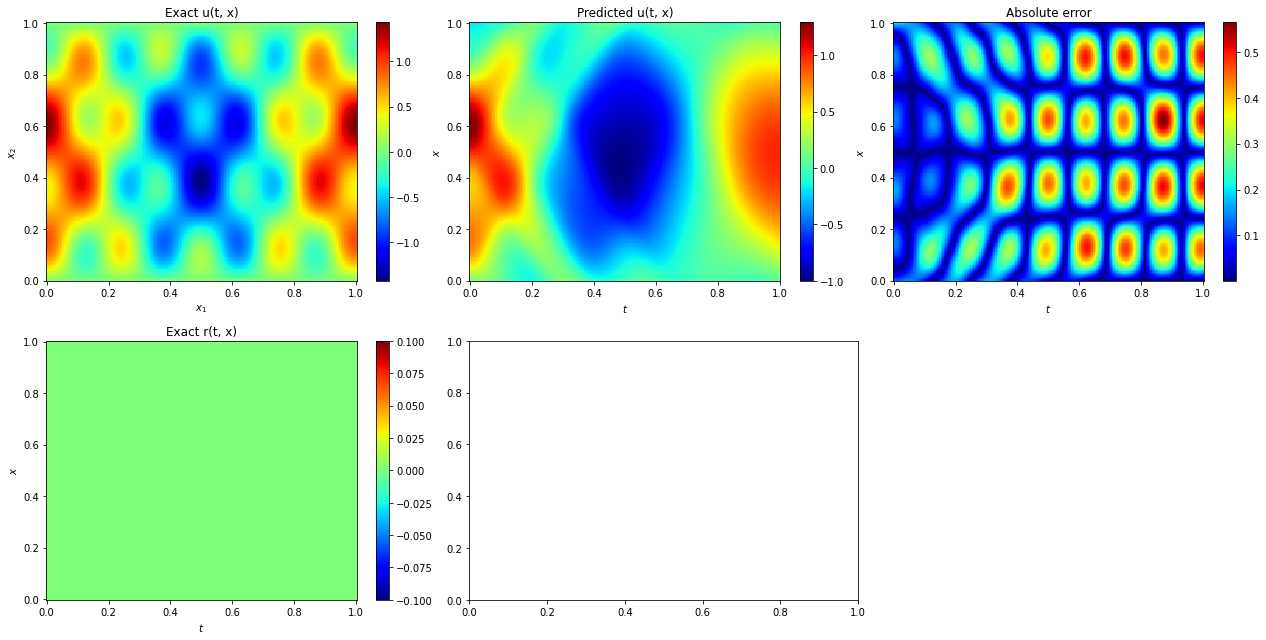

In [5]:
# Predictions
# u_pred = model.predict_u(X_star)
# r_pred = model.predict_r(X_star)

# Predictions

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

# print('elapsed: {:.2e}'.format(elapsed))

print('Relative L2 error_u: {:.2e}'.format(error_u))

U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')
r_star = griddata(X_star, r_star.flatten(), (t, x), method='cubic')
U_pred = griddata(X_star, u_pred.flatten(), (t, x), method='cubic')
# R_pred = griddata(X_star, r_pred.flatten(), (t, x), method='cubic')


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t, x, U_star, cmap='jet')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t, x, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 3)
plt.pcolor(t, x, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.subplot(2, 3, 4)
plt.pcolor(t, x, r_star, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 5)
plt.pcolor(t, x, r_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 6)
plt.pcolor(t, x, np.abs(r_star - r_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

In [6]:
# Define PINN model
a = 0.5
c = 2

kernel_size = 300

# Domain boundaries
ics_coords = np.array([[0.0, 0.0],  [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0],  [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0],  [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0],  [1.0, 1.0]])

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), name='Dirichlet BC2')
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), name='Forcing')



nIter =40000
bcbatch_size = 500
ubatch_size = 5000
mbbatch_size = 300



# Define model
mode = 'M4'
layers = [2, 500, 500, 500, 1]


nn = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, a,c)
r_star = r(X_star, a, c)

iterations = 1
methods = [  "mini_batch"]

result_dict =  dict((mtd, []) for mtd in methods)

for mtd in methods:
    print("Method: ", mtd)
    time_list = []
    error_u_list = []
    
    for index in range(iterations):

        print("Epoch: ", str(index+1))

        # Create residual sampler

        [elapsed, error_u] = test_method(mtd , layers,  ics_sampler, bcs_sampler, res_sampler, c ,kernel_size , X_star , u_star , r_star , nIter ,mbbatch_size , bcbatch_size , ubatch_size )


        print('elapsed: {:.2e}'.format(elapsed))
        print('Relative L2 error_u: {:.2e}'.format(error_u))

        time_list.append(elapsed)
        error_u_list.append(error_u)

    print("\n\nMethod: ", mtd)
    print("\naverage of time_list:" , sum(time_list) / len(time_list) )
    print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
    # print("average of error_r_list:" , sum(error_r_list) / len(error_r_list) )

    result_dict[mtd] = [time_list ,error_u_list]
    # scipy.io.savemat("M2_result_"+str(iterations)+"_"+mtd+".mat" , {'time_list':np.array(time_list),'error_u_list':np.array(error_u_list),'error_f_list':np.array(error_f_list)})

    scipy.io.savemat("./1DWave_database/"+mtd+"_1Dwave_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_bc"+str(mbbatch_size)+"_"+str(iterations)+".mat" , result_dict)

###############################################################################################################################################


Method:  mini_batch
Epoch:  1
mini_batch method is used
It: 100, Loss: 9.238e-01,  loss_bc1: 6.848e-02, loss_ics_u: 3.931e-01,  Loss_res: 6.576e-04 , Time: 4.89
It: 200, Loss: 6.458e-01,  loss_bc1: 7.923e-02, loss_ics_u: 2.403e-01,  Loss_res: 6.826e-03 , Time: 3.53
It: 300, Loss: 6.600e-01,  loss_bc1: 8.652e-02, loss_ics_u: 2.341e-01,  Loss_res: 1.875e-02 , Time: 3.44
It: 400, Loss: 5.494e-01,  loss_bc1: 6.093e-02, loss_ics_u: 2.009e-01,  Loss_res: 2.586e-02 , Time: 3.43
It: 500, Loss: 5.235e-01,  loss_bc1: 4.314e-02, loss_ics_u: 2.099e-01,  Loss_res: 1.742e-02 , Time: 3.35
It: 600, Loss: 4.532e-01,  loss_bc1: 4.553e-02, loss_ics_u: 1.763e-01,  Loss_res: 9.461e-03 , Time: 3.27
It: 700, Loss: 4.660e-01,  loss_bc1: 4.488e-02, loss_ics_u: 1.662e-01,  Loss_res: 4.375e-02 , Time: 3.38
It: 800, Loss: 4.010e-01,  loss_bc1: 5.502e-02, loss_ics_u: 1.294e-01,  Loss_res: 3.213e-02 , Time: 3.22
It: 900, Loss: 3.889e-01,  loss_bc1: 4.886e-02, loss_ics_u: 1.423e-01,  Loss_res: 6.523e-03 , Time: 3.26

In [ ]:
# Define PINN model
a = 0.5
c = 2

kernel_size = 300

# Domain boundaries
ics_coords = np.array([[0.0, 0.0],  [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0],  [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0],  [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0],  [1.0, 1.0]])

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), name='Dirichlet BC2')
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), name='Forcing')



nIter =40000
bcbatch_size = 500
ubatch_size = 5000
mbbatch_size = 300



# Define model
mode = 'M4'
layers = [2, 500, 500, 500, 1]


nn = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, a,c)
r_star = r(X_star, a, c)

iterations = 1
methods = [  "mini_batch"]

result_dict =  dict((mtd, []) for mtd in methods)

for mtd in methods:
    print("Method: ", mtd)
    time_list = []
    error_u_list = []
    
    for index in range(iterations):

        print("Epoch: ", str(index+1))

        # Create residual sampler

        [elapsed, error_u] = test_method(mtd , layers,  ics_sampler, bcs_sampler, res_sampler, c ,kernel_size , X_star , u_star , r_star , nIter ,mbbatch_size , bcbatch_size , ubatch_size )


        print('elapsed: {:.2e}'.format(elapsed))
        print('Relative L2 error_u: {:.2e}'.format(error_u))

        time_list.append(elapsed)
        error_u_list.append(error_u)

    print("\n\nMethod: ", mtd)
    print("\naverage of time_list:" , sum(time_list) / len(time_list) )
    print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
    # print("average of error_r_list:" , sum(error_r_list) / len(error_r_list) )

    result_dict[mtd] = [time_list ,error_u_list]
    # scipy.io.savemat("M2_result_"+str(iterations)+"_"+mtd+".mat" , {'time_list':np.array(time_list),'error_u_list':np.array(error_u_list),'error_f_list':np.array(error_f_list)})

    scipy.io.savemat("./1DWave_database/"+mtd+"_1Dwave_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_bc"+str(mbbatch_size)+"_"+str(iterations)+".mat" , result_dict)

###############################################################################################################################################


In [ ]:

import scipy.io

mode = 'M4'
mbbatch_size = 128
ubatch_size = 5000
bcbatch_size = 500
iterations = 40000

time_list = []
error_u_list = []
error_v_list = []
error_p_list = []
    
methods = ["mini_batch" , "full_batch"]
result_dict =  dict((mtd, []) for mtd in methods)

##Mini Batch
time_list = []
error_u_list = [ ]


result_dict["mini_batch"] = [time_list ,error_u_list]

print("\n\nMethod: ", mtd)
print("\naverage of time_list:" , sum(time_list) / len(time_list) )
print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )

##Full Batch
time_list = []
error_u_list = [ ]
error_v_list = []
error_p_list = []

result_dict["full_batch"] = [time_list ,error_u_list ,error_v_list ,  error_p_list]

print("\n\nMethod: ", mtd)
print("\naverage of time_list:" , sum(time_list) / len(time_list) )
print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
print("average of error_v_list:" , sum(error_v_list) / len(error_v_list) )
print("average of error_p_list:" , sum(error_p_list) / len(error_p_list) )


scipy.io.savemat("./dataset/1DWave_database_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_"+str(bcbatch_size)+"_"+str(iterations)+".mat" , result_dict)



In [ ]:
# Train model
itertaions = 80001
log_NTK = True # Compute and store NTK matrix during training
update_lam = True # Compute and update the loss weights using the NTK 



**Training Loss**

In [ ]:
loss_res = model.loss_res_log
loss_bcs = model.loss_bcs_log
loss_u_t_ics = model.loss_ut_ics_log

fig = plt.figure(figsize=(6, 5))
plt.plot(loss_res, label='$\mathcal{L}_{r}$')
plt.plot(loss_bcs, label='$\mathcal{L}_{u}$')
plt.plot(loss_u_t_ics, label='$\mathcal{L}_{u_t}$')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

**Model Prediction**

In [ ]:


# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

print('Relative L2 error_u: %e' % (error_u))

In [ ]:
U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')
r_star = griddata(X_star, r_star.flatten(), (t, x), method='cubic')
U_pred = griddata(X_star, u_pred.flatten(), (t, x), method='cubic')
R_pred = griddata(X_star, r_pred.flatten(), (t, x), method='cubic')


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t, x, U_star, cmap='jet')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t, x, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 3)
plt.pcolor(t, x, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.subplot(2, 3, 4)
plt.pcolor(t, x, r_star, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 5)
plt.pcolor(t, x, R_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 6)
plt.pcolor(t, x, np.abs(r_star - R_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

**NTK Eigenvalues**

In [ ]:
# Create empty lists for storing the eigenvalues of NTK
lam_K_u_log = []
lam_K_ut_log = []
lam_K_r_log = []

# Restore the NTK
K_u_list = model.K_u_log
K_ut_list = model.K_ut_log
K_r_list = model.K_r_log

K_list = []
    
for k in range(len(K_u_list)):
    K_u = K_u_list[k]
    K_ut = K_ut_list[k]
    K_r = K_r_list[k]
    
    # Compute eigenvalues
    lam_K_u, _ = np.linalg.eig(K_u)
    lam_K_ut, _ = np.linalg.eig(K_ut)
    lam_K_r, _ = np.linalg.eig(K_r)
    # Sort in descresing order
    lam_K_u = np.sort(np.real(lam_K_u))[::-1]
    lam_K_ut = np.sort(np.real(lam_K_ut))[::-1]
    lam_K_r = np.sort(np.real(lam_K_r))[::-1]
    
    # Store eigenvalues
    lam_K_u_log.append(lam_K_u)
    lam_K_ut_log.append(lam_K_ut)
    lam_K_r_log.append(lam_K_r)

In [ ]:
#  Eigenvalues of NTK
fig = plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)

plt.plot(lam_K_u_log[0], label = '$n=0$')
plt.plot(lam_K_u_log[1], '--', label = '$n=10,000$')
plt.plot(lam_K_u_log[4], '--', label = '$n=40,000$')
plt.plot(lam_K_u_log[-1], '--', label = '$n=80,000$')
plt.xscale('log')
plt.yscale('log')

plt.title(r'Eigenvalues of ${K}_u$')

plt.subplot(1,3,2)
plt.plot(lam_K_ut_log[0], label = '$n=0$')
plt.plot(lam_K_ut_log[1], '--',label = '$n=10,000$')
plt.plot(lam_K_ut_log[4], '--', label = '$n=40,000$')
plt.plot(lam_K_ut_log[-1], '--', label = '$n=80,000$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}_{u_t}$')

ax =plt.subplot(1,3,3)
plt.plot(lam_K_r_log[0], label = '$n=0$')
plt.plot(lam_K_r_log[1], '--', label = '$n=10,000$')
plt.plot(lam_K_r_log[4], '--', label = '$n=40,000$')
plt.plot(lam_K_r_log[-1], '--', label = '$n=80,000$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}_{r}$')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.35, -0.02),
            borderaxespad=0, bbox_transform=fig.transFigure, ncol=4)
plt.tight_layout()
plt.show()

**Evolution of NTK Weights**

In [ ]:
if update_lam == True:

  lam_u_log = model.lam_u_log
  lam_ut_log = model.lam_ut_log
  lam_r_log = model.lam_r_log

In [ ]:
fig = plt.figure(figsize=(6, 5))
plt.plot(lam_u_log, label='$\lambda_u$')
plt.plot(lam_ut_log, label='$\lambda_{u_t}$')
plt.plot(lam_r_log, label='$\lambda_{r}$')
plt.xlabel('iterations')
plt.ylabel('$\lambda$')
plt.yscale('log')
plt.legend( )
plt.tight_layout()
plt.show()